# HW #3: Time-Series Models

## Imports

In [497]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 
sns.set(font_scale = 1.2, rc={'figure.figsize':(15,8)})
import warnings
warnings.filterwarnings('ignore')

## Data

In [498]:
data = pd.read_excel("data/hw_1_data.xlsx").rename(columns={"Unnamed: 0": "Date"}).set_index("Date")
data.head()

,SPY US Equity,AAPL US Equity,CL1 Comdty,DXY Curncy,HFRIMTI Index,Rate Convexity,Portfolio,10-yr Yields,Dvd-Price Ratio
Date,,,,,,,,,
1999-10-31,0.064078,0.265523,-0.112607,0.005277,0.0235,0.025013,0.000072,0.06024,0.010868
1999-11-30,0.016651,0.221519,0.130575,0.029578,0.0250,0.027722,0.105636,0.06191,0.010690
1999-12-31,0.057089,0.050465,0.041074,-0.001177,0.0509,0.040543,0.042261,0.06442,0.009465
2000-01-31,-0.049787,0.009123,0.079687,0.032002,0.0155,0.034617,0.031966,0.06665,0.009961
2000-02-29,-0.015226,0.104820,0.100941,0.007515,0.0596,-0.038410,0.063138,0.06409,0.010792


## 1. Forecast Regressions

SPY returns are our dependent variable:

In [499]:
y = data['SPY US Equity']

Define a regression summary function that gives us the parameters and statistics we want:

In [500]:
def reg_summary(model):
    reg_summary = model.params.to_frame('Parameters')
    reg_summary['t-stats'] = round(model.tvalues, 3)
    reg_summary.loc[r'$R^{2}$'] = [model.rsquared, "-"]

    return round(reg_summary, 3)

### 1.1a

Try to explain future SPY returns using dividend-price ratio:

In [501]:
X = sm.add_constant(data['Dvd-Price Ratio']).shift(1)
model1 = sm.OLS(y,X,missing='drop').fit()

reg_summary(model1)

,Parameters,t-stats
const,-0.014,-1.139
Dvd-Price Ratio,1.068,1.638
$R^{2}$,0.011,-


### 1.1b

Try to explain future SPY returns using 10-year yields:

In [502]:
X = sm.add_constant(data['10-yr Yields']).shift(1)
model2 = sm.OLS(y,X,missing='drop').fit()

reg_summary(model2)

,Parameters,t-stats
const,0.025,3.119
10-yr Yields,-0.548,-2.558
$R^{2}$,0.027,-


### 1.1c

Try to explain future SPY returns using both divident-price ratio and 10-year yields:

In [503]:
X = sm.add_constant(data[['Dvd-Price Ratio','10-yr Yields']]).shift(1)
model3 = sm.OLS(y,X,missing='drop').fit()

reg_summary(model3)

,Parameters,t-stats
const,0.025,1.065
Dvd-Price Ratio,-0.013,-0.015
10-yr Yields,-0.551,-1.95
$R^{2}$,0.027,-


### 1.2a

Run autoregressions for both dividend-price ratio and 10-year yields:

In [504]:
y = data['Dvd-Price Ratio']
X = sm.add_constant(data['Dvd-Price Ratio']).shift(1)
model4 = sm.OLS(y,X,missing='drop').fit()

reg_summary(model4)

,Parameters,t-stats
const,0.002,3.846
Dvd-Price Ratio,0.888,30.585
$R^{2}$,0.799,-


In [505]:
y = data['10-yr Yields']
X = sm.add_constant(data['10-yr Yields']).shift(1)
model5 = sm.OLS(y,X,missing='drop').fit()

reg_summary(model5)

,Parameters,t-stats
const,0.001,1.353
10-yr Yields,0.976,74.319
$R^{2}$,0.959,-


### 1.2b

**Does the autoregressive nature of X present problems for OLS estimates?**

We see that for both the Dividend Ratio and the 10-yr Yield, the $R^{2}$ is large and the $\beta$ is close to 1 and statistically significant.

One of the assumptions for the classic OLS results, (the Gauss-Markov Theorem,) is that epsilon does not have serial correlation. Typically, if we use a regressor such as these two variables, with such high serial correlation, this will induce serial correlation in epsilon. Accordingly, we may not be able to trust the classic t-stats, as noted in the "Notes" of the package regression summaries (model.summary()).

Furthermore, this high serial correlation of X means that in a regression such as that of 1(a), we may have significant small-sample bias.

Accordingly, time-series regressions where the X has high serial correlation tend to rely on large-sample properties and adjusted t-stats.

## 2. OOS $R^{2}$

Set up x and y and the minimum number of observations we want:

In [506]:
X = sm.add_constant(data[['Dvd-Price Ratio','10-yr Yields']]).shift(1)
y = data['SPY US Equity']
min_obv = 60

Starting at $t = 60$, loop through each time and observe the error when predicting future SPY returns with a regression (using dividend-price ratio and 10-year yields as factors) as opposed to using the mean as the prediction:

In [511]:
err_x, err_null = [], []

for i in range(min_obv, len(y)):

    ### Data up to t
    currX = X.iloc[:i]
    currY = y.iloc[:i]
    
    ### Fit the model 
    model = sm.OLS(currY, currX, missing='drop').fit()
    
    ### Use the model to predict next SPY returns using the most recent x values
    pred = model.predict(X.iloc[[i]])[0]
    
    ### Forecast error of the regression
    err_x.append(y.iat[i] - pred)
    
    ### Null error is the actual value - the mean of previous values
    err_null.append(y.iat[i] - currY.mean())

### Calculate out-of-sample r2 using the errors we calculated
r_sqr_oos = 1 - np.square(err_x).sum() / np.square(err_null).sum()
print('OOS r-squared:' + str(round(r_sqr_oos, 4)))

OOS r-squared:-0.0185


## 3. Time-Series Models of Volatility

We are using SPY, and we set up the initial parameters we are given:

In [438]:
spy = data['SPY US Equity']

var_1 = (0.15 * (1 / (12**0.5)))**2
theta = 0.97

Calculate the Expanding Series and Rolling Window estimates:

In [439]:
### Expanding Window
var = (spy**2).shift(1).expanding().mean().to_frame('Expanding Window')

### Rolling Window
var['Rolling Window'] = (spy**2).shift(1).rolling(60).mean() 

Using the arch package, fit a GARCH(1, 1) model. We will use the parameters generated to find our estimates:

In [440]:
GARCH = arch_model(spy, vol='Garch', p=1, o=0, q=1, dist='Normal')

GARCH_model = GARCH.fit()

GARCH_model.params

Iteration:      1,   Func. Count:      6,   Neg. LLF: 92833051.57492794
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1061937.8929357708
Iteration:      3,   Func. Count:     28,   Neg. LLF: 15.616654305919681
Iteration:      4,   Func. Count:     36,   Neg. LLF: 686041.1518980877
Iteration:      5,   Func. Count:     47,   Neg. LLF: -339.3344361403002
Iteration:      6,   Func. Count:     54,   Neg. LLF: 116419382.52249691
Iteration:      7,   Func. Count:     61,   Neg. LLF: -435.53119945743936
Iteration:      8,   Func. Count:     67,   Neg. LLF: -432.61593581073873
Iteration:      9,   Func. Count:     73,   Neg. LLF: -431.6293576469063
Iteration:     10,   Func. Count:     79,   Neg. LLF: -439.9132064497704
Iteration:     11,   Func. Count:     85,   Neg. LLF: -441.2947282201124
Iteration:     12,   Func. Count:     91,   Neg. LLF: -434.2189514571762
Iteration:     13,   Func. Count:     97,   Neg. LLF: -442.06911593307973
Iteration:     14,   Func. Count:    102,   Neg. L

mu          0.009173
omega       0.000088
alpha[1]    0.219932
beta[1]     0.740746
Name: params, dtype: float64

We have $\theta$ so we do not need the step below to find our estimates. However, this is an example of how to use the arch package to fit an IGARCH model. The package has several methods that could be useful in other applications.

In [441]:
IGARCH = arch_model(spy)

IGARCH.volatility = EWMAVariance(theta)

IGARCH_model = IGARCH.fit()

IGARCH_model.params

Iteration:      1,   Func. Count:      3,   Neg. LLF: 1797058.7870452015
Iteration:      2,   Func. Count:     10,   Neg. LLF: -421.70203145874507
Iteration:      3,   Func. Count:     11,   Neg. LLF: -421.7020314593276
Optimization terminated successfully    (Exit mode 0)
            Current function value: -421.70203145874507
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3


mu    0.006533
Name: params, dtype: float64

We calculate our variance estimates for the GARCH and IGARCH models:

In [442]:
var[['GARCH','IGARCH']] = None

### Initialize with the given parameter
var.iloc[0,2:] = var_1 

### Simulate the rest of the period using the initial variance given
for i in range(1, len(var)):
    ### Forecast variance by plugging the GARCH and IGARCH parameters into their respective equations
    var['IGARCH'].iloc[i] = var['IGARCH'].iloc[i-1] * theta + (1-theta)*(spy.iloc[i-1]**2)
    var['GARCH'].iloc[i] = GARCH_model.params['omega'] + var['GARCH'].iloc[i-1] * GARCH_model.params['beta[1]'] + GARCH_model.params['alpha[1]']*(spy.iloc[i-1]**2)
    
var = var.dropna()

var.head()

,Expanding Window,Rolling Window,GARCH,IGARCH
Date,,,,
2004-10-31,0.002215,0.002215,0.000664,0.001847
2004-11-30,0.002181,0.002149,0.000616,0.001797
2004-12-31,0.002178,0.002177,0.000981,0.001802
2005-01-31,0.002158,0.002138,0.001015,0.001776
2005-02-28,0.002132,0.002105,0.00095,0.001737


Let's plot our volatility estimates now:

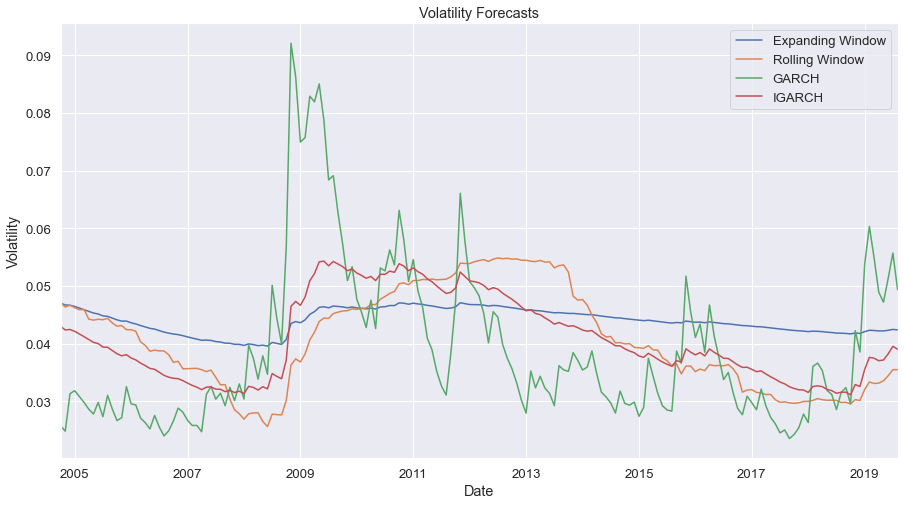

In [508]:
### Convert variance to volatility
vol = var**.5

vol.plot()
plt.title('Volatility Forecasts')
plt.ylabel('Volatility')

plt.show()

Volatility estimates for October of 2008:

In [444]:
vol.loc["2008-10"]

,Expanding Window,Rolling Window,GARCH,IGARCH
Date,,,,
2008-10-31,0.040722,0.030171,0.056839,0.037187


Volatility estimates for December of 2018:

In [445]:
vol.loc["2018-12"]

,Expanding Window,Rolling Window,GARCH,IGARCH
Date,,,,
2018-12-31,0.041776,0.030146,0.038554,0.032573
